# Example 5. Uncalibrated modulators: Oblique plane structured illumination microscopy

Load raw [oblique plane structured illumination microscopy (OPSIM)](https://www.biorxiv.org/content/10.1101/2022.05.19.492671v1.full), process data for rotation and registration, determine SIM pattern infromation, and run reconstruction.

Instrument designed and built by Bingying Chen, Bo-Jui Chang, and Reto Fiolka.  
Cardiomyocyte cell samples labeled for alpha-actinin 2 by James Hayes and Dylan Burnette.   
All imaging by Reto Fiolka. 

### Download data from Zenodo and extract

Data available from [OPSIM Zenodo repository](https://zenodo.org/record/6481084#.YmVM-7lOmHs).  Please download and extract "1_CH00_000000.tif" into data/example_005/raw_data. Once this is done, you can run this example.

### Import libraries

In [1]:
import numpy as np
from numpy import fft
from pathlib import Path
import mcsim.analysis.sim_reconstruction as sim
from mcsim.analysis import analysis_tools
from localize_psf import rois
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm
from skimage.transform import rotate
import napari
import tifffile
import gc
from example005_resources.deskew_opm_data import deskew
import itk

### Define data paths to raw OPSIM stack and 2D PSF extracted from many beads

In [2]:
opsim_file_path = Path("data", "example_005", "raw_data", "1_CH00_000000.tif")
psf_file_path = Path("example005_resources", "psf2d.tif")

### Define experimental metadata

In [3]:
# extracted from text file provided with acquisition
n_colors = 1
n_angles = 3
n_phases = 3
ns = 251
ny = 200
nx = 1024
pixel_size = 0.114 # um
ds = 0.320 # um - scan step size, not coverslip z
na = 1.0 # Snouty NA
excitation_wavelengths = 0.488 # um
emission_wavelengths = 0.520 # um
tilt_angle = 45.0

# transformed pixel spacing. qi2lab deskew deskews onto an isotropic grid in xy
coverslip_dz = pixel_size * np.sin(tilt_angle)
coverslip_dy = pixel_size
coverslip_dx = pixel_size

### Load and parse data into angles and phases

In [4]:
# create array to hold all raw opsim images
sim_images = np.zeros((n_colors,n_angles,n_phases,ns,ny,nx),dtype=np.uint16)

# loop through TIFF file and load each raw opsim image into proper metadata location
page_idx = 0
with tifffile.TiffFile(opsim_file_path) as tif:
    n_pages = len(tif.pages)
    for channel_idx in range(n_colors):
        for angle_idx in range(n_angles):
            for phase_idx in range(n_phases):
                for scan_idx in range(ns):
                    sim_images[channel_idx,angle_idx,phase_idx,scan_idx,:,:] = tif.pages[page_idx].asarray()
                    page_idx = page_idx + 1

### Visualize OPM SIM data in native reference frame

In [6]:
# add images to napari viewer with scale information
viewer = napari.view_image(sim_images,name='Raw OPSIM data',scale=(1,1,1,ds,pixel_size,pixel_size))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','s','y','x']

### Calculate deskewed widefield equivalent images for registration
  
Orthogonal deskew function for OPM extracted from [qi2lab OPM package](https://www.github.com/qi2lab/opm). 

In [16]:
# deskew one channel/angle/phase to get the size of the image
test_deskew = deskew(sim_images[0,0,0,:],tilt_angle,ds,pixel_size)
n_coverslip_z = test_deskew.shape[0]
n_coverslip_y = test_deskew.shape[1]
n_coverslip_x = test_deskew.shape[2]
coverslip_wf_images = np.zeros((n_colors,n_angles,n_coverslip_z,n_coverslip_y,n_coverslip_x),dtype=np.uint16)

# perform deskewing for all widefield equivalent views (average over phases)
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            image_plane = deskew(np.flipud(np.nanmean(sim_images[channel_idx,angle_idx,:,:,:,:],axis=0)),tilt_angle,ds,pixel_size)
            coverslip_wf_images[channel_idx,angle_idx,:] = image_plane

# clean up variables
del test_deskew
gc.collect()

500

### Rotate deskewed widefield equivalent images with prior info from instrument

In [17]:
# pad images to be square
max_size = np.maximum(n_coverslip_y,n_coverslip_x)

if max_size > n_coverslip_y:
    pad_amount_y = np.abs(max_size-n_coverslip_y)//2
else:
    pad_amount_y = 0
if max_size > n_coverslip_x:
    pad_amount_x = np.abs(max_size-n_coverslip_x)//2
else:
    pad_amount_x = 0

pad_width = ((0,0),(0,0),(0,0),(pad_amount_y,pad_amount_y+1),(pad_amount_x,pad_amount_x))

coverslip_rotated_wf_images = np.pad(coverslip_wf_images,pad_width=pad_width)

# rotation angle guesses from instrument design
rotation = [60,0,-60]

# perform rotation across all z planes for each channel + angle
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for z_idx in range(n_coverslip_z):
            rotated_plane = rotate(coverslip_rotated_wf_images[channel_idx,angle_idx,z_idx,:,:],
                                    angle=rotation[angle_idx],
                                    center=None,
                                    resize=False,
                                    mode='constant',
                                    cval=0,
                                    preserve_range=True)
            coverslip_rotated_wf_images[channel_idx,angle_idx,z_idx,:,:] = rotated_plane

# clean up variables
del coverslip_wf_images
gc.collect()

0

### Determine image registration in coverslip reference frame using deskewed and rotated widefield images

In [9]:
# create ITK array for fixed view
# itk-elastix currently supports np.float32 only
channel_idx = 0
angle_idx = 1
fixed_image_a001 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# create empty rigid transformation object
parameter_object_rigid = itk.ParameterObject.New()
default_rigid_parameter_map = parameter_object_rigid.GetDefaultParameterMap('rigid')
parameter_object_rigid.AddParameterMap(default_rigid_parameter_map)

# create empty affine transformation object
parameter_object_affine = itk.ParameterObject.New()
default_affine_parameter_map = parameter_object_affine.GetDefaultParameterMap('affine',4)
default_affine_parameter_map['FinalBSplineInterpolationOrder'] = ['0']
parameter_object_affine.AddParameterMap(default_affine_parameter_map)

# Call registration functions to determine registration of rotated view (angle_idx=[0,2]) to center view (angle_idx=1)

# create ITK array for +60 rotated view
# itk-elastix currently supports np.float32 only
angle_idx = 0
moving_image_a000 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# register angle_idx=0 to angle_idx=1
# begin with rigid registration
result_image_a000_rigid, result_transform_parameters_a000_to_a001_rigid = itk.elastix_registration_method(
    fixed_image_a001, moving_image_a000,
    parameter_object=parameter_object_rigid,
    log_to_console=False)

# refine rigid transformation with affine registration
result_image_a000_affine, result_transform_parameters_a000_to_a001_affine = itk.elastix_registration_method(
    fixed_image_a001, result_image_a000_rigid,
    parameter_object=parameter_object_affine,
    log_to_console=False)

# clean up variables for +60 rotated view
del moving_image_a000, result_image_a000_rigid, #result_image_a000_affine
gc.collect()

# create ITK array for -60 rotated view
# itk-elastix currently supports np.float32 only
angle_idx = 2
moving_image_a002 = itk.GetImageFromArray(coverslip_rotated_wf_images[channel_idx,angle_idx,:].astype(np.float32))

# register angle_idx=2 to angle_idx=1
# begin with rigid registration
result_image_a002_rigid, result_transform_parameters_a002_to_a001_rigid = itk.elastix_registration_method(
    fixed_image_a001, moving_image_a002,
    parameter_object=parameter_object_rigid,
    log_to_console=False)

# refine rigid transformation with affine registration
result_image_a002_affine, result_transform_parameters_a002_to_a001_affine = itk.elastix_registration_method(
    fixed_image_a001, result_image_a002_rigid,
    parameter_object=parameter_object_affine,
    log_to_console=False)

# clean up variables for -60 rotated view
del moving_image_a002, result_image_a002_rigid, #result_image_a002_affine, fixed_image_a001
del coverslip_rotated_wf_images
gc.collect()

0

In [22]:
# Create Groupwise Parameter Object
parameter_object = itk.ParameterObject.New()
groupwise_parameter_map = parameter_object.GetDefaultParameterMap('groupwise')
parameter_object.AddParameterMap(groupwise_parameter_map)

temp = np.zeros((3,*result_image_a002_affine.shape),dtype=np.float32)

temp[0,:]=result_image_a000_affine
temp[1,:]=fixed_image_a001
temp[2,:]=result_image_a002_affine

image_itk_4D = itk.image_view_from_array(temp)

result_image, result_transform_parameters = itk.elastix_registration_method(
    image_itk_4D, image_itk_4D,
    parameter_object=parameter_object,
    log_to_console=True)

RuntimeError: D:\a\im\_skbuild\win-amd64-3.10\cmake-build\_deps\elx-src\Core\Main\itkElastixRegistrationMethod.hxx:267:
ITK ERROR: ElastixRegistrationMethod(000001EF66BD65C0): Internal elastix error: See elastix log (use LogToConsoleOn() or LogToFileOn()).

### Deskew all raw OPSIM images

In [9]:
# deskew one channel/angle/phase to get the size of the image
test_deskew = deskew(sim_images[0,0,0,:],tilt_angle,ds,pixel_size)
n_coverslip_z = test_deskew.shape[0]
n_coverslip_y = test_deskew.shape[1]
n_coverslip_x = test_deskew.shape[2]

# create array to hold all deskewed images
coverslip_opsim_images = np.zeros((n_colors,n_angles,n_phases,n_coverslip_z,n_coverslip_y,n_coverslip_x),dtype=np.uint16)

# perform deskewing for all raw opsim views
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:] = deskew(np.flipud(sim_images[channel_idx,angle_idx,phase_idx,:,:,:]),tilt_angle,ds,pixel_size)

# clean up variables
del test_deskew, sim_images
gc.collect()

32758

### Rotate deskewed raw OPSIM images

In [10]:
# pad images to be square to hold rotated images
max_size = np.maximum(n_coverslip_y,n_coverslip_x)

if max_size > n_coverslip_y:
    pad_amount_y = np.abs(max_size-n_coverslip_y)//2
else:
    pad_amount_y = 0
if max_size > n_coverslip_x:
    pad_amount_x = np.abs(max_size-n_coverslip_x)//2
else:
    pad_amount_x = 0

pad_width = ((0,0),(0,0),(0,0),(0,0),(pad_amount_y,pad_amount_y+1),(pad_amount_x,pad_amount_x))
rotated_coverslip_opsim_images = np.pad(coverslip_opsim_images,pad_width=pad_width)

# rotation angle guesses from instrument design
rotation = [61,0,-60]

# perform rotation across all z planes for each channel + angle
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            for z_idx in range(n_coverslip_z):
                rotated_plane = rotate(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:],
                                        angle=rotation[angle_idx],
                                        center=None,
                                        resize=False,
                                        mode='constant',
                                        cval=0,
                                        preserve_range=True)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,z_idx,:,:] = rotated_plane

# clean up variables
del coverslip_opsim_images
gc.collect()

0

### Register deskewed raw OPSIM images using transformation matrices found using deskewed WF images

In [11]:
# loop over all channel/angle/phase and apply transformations for angle_idx=[0,2] to angle_idx=1
for channel_idx in range(n_colors):
    for angle_idx in range(n_angles):
        for phase_idx in range(n_phases):
            if angle_idx == 0:
                result_image_transformix = itk.transformix_filter(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:].astype(np.float32),result_transform_parameters_a000_to_a001_rigid)
                result_image_transformix = itk.transformix_filter(result_image_transformix.astype(np.float32),result_transform_parameters_a000_to_a001_affine)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:]=result_image_transformix.astype(np.uint16)
            elif angle_idx == 2:
                result_image_transformix = itk.transformix_filter(rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:].astype(np.float32),result_transform_parameters_a002_to_a001_rigid)
                result_image_transformix = itk.transformix_filter(result_image_transformix.astype(np.float32),result_transform_parameters_a002_to_a001_affine)
                rotated_coverslip_opsim_images[channel_idx,angle_idx,phase_idx,:,:,:]=result_image_transformix.astype(np.uint16)

### Visualize registered deskewed images in coverslip reference frame

In [12]:
# add images to napari viewer with scale information
viewer = napari.view_image(rotated_coverslip_opsim_images[0,0,:],name='Registered deskewed angle 0',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(rotated_coverslip_opsim_images[0,1,:],name='Registered deskewed angle 1',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(rotated_coverslip_opsim_images[0,2,:],name='Registered deskewed angle 2',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','z','y','x']

Exception in callback BaseAsyncIOLoop._handle_events(7952, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(7952, 1)>
Traceback (most recent call last):
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\zmq\eventloop\zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\zmq\eventloop\zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\zmq\eventloop\zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-pac

### Set ROI to middle of data and extract crop

In [24]:
# set yx width of ROI
roi_sy=449
roi_sx=389
roi = rois.get_centered_roi([rotated_coverslip_opsim_images.shape[4]//2, rotated_coverslip_opsim_images.shape[5]//2], [roi_sy, roi_sx])

z_roi_low = 30
z_roi_high = 130

# extract crop
opsim_images_to_process = rotated_coverslip_opsim_images[:,:,:,z_roi_low:z_roi_high,roi[0]:roi[1],roi[2]:roi[3]]

# extract shape of cropped data
nz_cropped = opsim_images_to_process.shape[3]
ny_cropped = opsim_images_to_process.shape[4]
nx_cropped = opsim_images_to_process.shape[5]

### Visualize cropped data to pick "best" slice

In [20]:
# add images to napari viewer with scale information
viewer = napari.view_image(opsim_images_to_process[0,0,:],name='Registered deskewed angle 0',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(opsim_images_to_process[0,1,:],name='Registered deskewed angle 1',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))
viewer.add_image(opsim_images_to_process[0,2,:],name='Registered deskewed angle 2',scale=(1,coverslip_dz,coverslip_dy,coverslip_dx))

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

# label sliders in napari viewer
viewer.dims.axis_labels = ['c','a','p','z','y','x']

Exception in callback BaseAsyncIOLoop._handle_events(10256, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(10256, 1)>
Traceback (most recent call last):
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\tornado\platform\asyncio.py", line 189, in _handle_events
    handler_func(fileobj, events)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\zmq\eventloop\zmqstream.py", line 577, in _handle_events
    self._handle_recv()
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\zmq\eventloop\zmqstream.py", line 606, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-packages\zmq\eventloop\zmqstream.py", line 556, in _run_callback
    callback(*args, **kwargs)
  File "c:\Users\dpshe\miniconda3\envs\mcSIMpy10test\lib\site-p

### Find SIM peaks for each angle
See [this section of the I2K mcSIM tutorial](https://youtu.be/mDar-MjMtW0?t=6421) video and our [Nikon N-SIM processing tutorial](https://github.com/QI2lab/I2K2022-SIM/blob/0660281c28a809fdc09c36b00903b9230feb4d9c/example_004_Nikon_NSIM.ipynb) for how use the code block to find SIM frequencies.

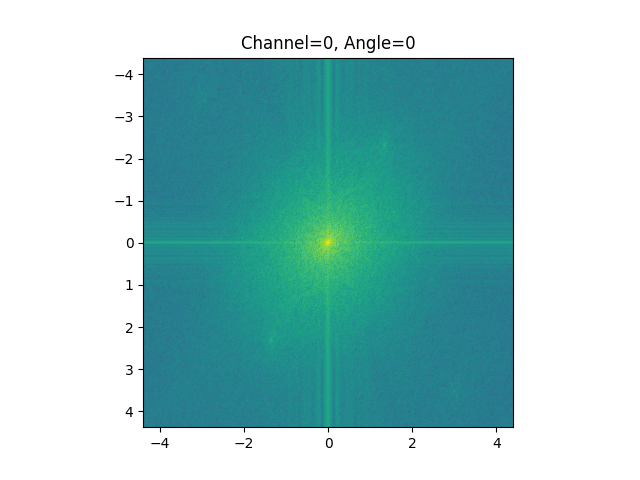

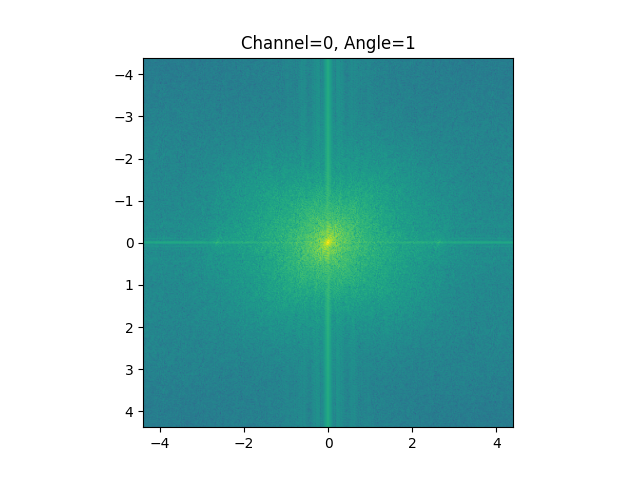

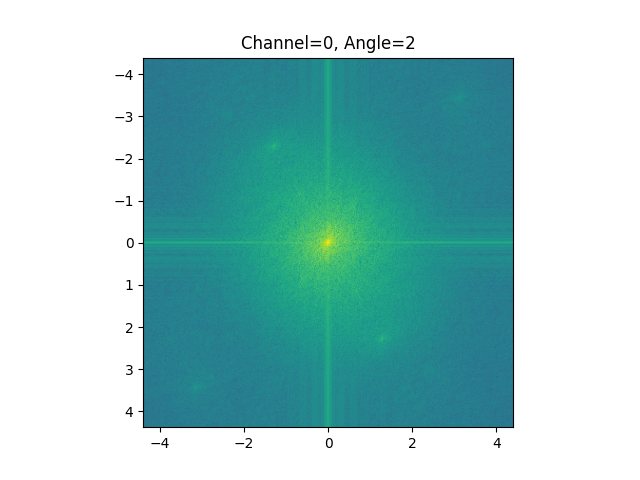

In [21]:
%matplotlib widget

# set "best" slice as determined from data
z_center_idx=23

for ch_idx in range(n_colors):

    # extract iamges
    image_set = opsim_images_to_process[ch_idx,:,:,z_center_idx,:,:]

    # calculate FFTs on grid with correct spatial dimensions
    dx = np.round(coverslip_dx,3)
    dy = np.round(coverslip_dy,3)
    nx = nx_cropped
    ny = ny_cropped
    fxs = analysis_tools.get_fft_frqs(nx, dx)
    df = fxs[1] - fxs[0]
    fys = analysis_tools.get_fft_frqs(ny, dy)
    ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)
    for ii in range(image_set.shape[0]):
        ft = fft.fftshift(fft.fft2(fft.ifftshift(np.squeeze(image_set[ii, 0, :]))))

        figh = plt.figure()
        plt.title('Channel='+str(ch_idx)+", Angle="+str(ii))
        plt.imshow(np.abs(ft), norm=PowerNorm(gamma=0.1,vmin=65,vmax=1.5e7),
                    extent=[fxs[0] - 0.5 * df, fxs[-1] + 0.5 * df, fys[-1] + 0.5 * df, fys[0] - 0.5 * df])
        plt.show()

### Setup 2D-SIM processing

In [34]:
# frequency guess from above. in k_x, k_y order
frq_guess = [[-1.33,2.3], [-2.6,0.003], [-1.28,-2.3]]
# phase guesses from prior knowledge
phase_guess = [[0, -4*np.pi/3,-2*np.pi/3], [0, -4*np.pi/3,-2*np.pi/3], [0, -4*np.pi/3,-2*np.pi/3]]

# algorithm parameters
wiener_parameter = 0.5
band0_exclusion_fraction = 0.5

### Load point spread function and calculate optical transfer function for each angle

2D PSF extracted from OPSIM data of beads by Reto Fiolka and Peter Brown using [qi2lab localize-psf package](https://www.github.com/qi2lab/localize-psf).  

In [37]:
# load PSF from disk and tranpose to match metadata from raw data
psf2d = np.transpose(tifffile.imread(psf_file_path))
ny_psf, nx_psf = psf2d.shape

# create one PSF for each angle
psfs = np.asarray([rotate(psf2d, rotation[0], center=None, resize=False, mode='constant', cval=0, preserve_range=True),
                   psf2d,
                   rotate(psf2d, rotation[2], center=None, resize=False, mode='constant', cval=0, preserve_range=True)])

# pad to get size of image
if np.mod(ny_psf + ny_cropped, 2) != 0 or np.mod(nx_psf + nx_cropped, 2) != 0:
    raise ValueError()

# pad each PSF
ny_pad = int((ny_cropped - ny_psf) / 2)
nx_pad = int((nx_cropped - nx_psf) / 2)
psfs_padded = []
for p in psfs:
    psfs_padded.append(np.pad(p, ((ny_pad, ny_pad), (nx_pad, nx_pad)), mode="constant"))
psfs_padded = np.asarray(psfs_padded)

# get spatial frequencies on correct grid
fxs = fft.fftshift(fft.fftfreq(nx_cropped, coverslip_dx))
df = fxs[1] - fxs[0]
fys = fft.fftshift(fft.fftfreq(ny_cropped, coverslip_dy))
ff = np.sqrt(np.expand_dims(fxs, axis=0)**2 + np.expand_dims(fys, axis=1)**2)

# create OTF for each angle
fmax = 1 / (0.5 * emission_wavelengths / na)
otfs = []
for p in psfs_padded:
    otf = fft.fftshift(fft.fft2(fft.ifftshift(p)))
    otf = otf / np.max(np.abs(otf))
    otf[np.abs(otf) < 0.005] = 0
    otf[ff > fmax] = 0
    otf = np.abs(otf)

    otfs.append(otf)
otfs = np.asarray(otfs)

### Run 2D-SIM processing for z slice used to calculate frequencies above and extract reconstruction parameters
  
Modifications to [qi2lab mcSIM package](https://www.github.com/qi2lab/mcSIM) to handle OPSIM data by Peter Brown.

In [38]:
# define save path
save_path = Path("data", "example_005", "reconstruction", "mito", "center_z_plane")

# create SIM reconstruction object for z_center_idx 
dset_one = sim.SimImageSet({'pixel_size': coverslip_dx, 'na': na, 'wavelength': emission_wavelengths},
                               opsim_images_to_process[0, :, :, z_center_idx, :],
                               frq_guess=frq_guess,
                               phases_guess=phase_guess,
                               wiener_parameter=wiener_parameter,
                               phase_estimation_mode="wicker-iterative",
                               max_phase_err=40 * np.pi / 180,
                               combine_bands_mode="fairSIM", 
                               otf=otfs,
                               fmax_exclude_band0=band0_exclusion_fraction,
                               min_p2nr=0.8,
                               gain=1, 
                               background=0,
                               save_dir=save_path,
                               save_suffix='_z'+str(z_center_idx).zfill(3)+'_ch'+str(0).zfill(3),
                               interactive_plotting=False)

# perform reconstruction, plot figures, save
dset_one.reconstruct()
dset_one.plot_figs()
dset_one.save_imgs()
dset_one.save_result()

# save reconstruction parameter for use on full stack
frqs = np.array(dset_one.frqs, copy=True)
phases = np.array(dset_one.phases, copy=True)
mod_depths = np.array(dset_one.mod_depths, copy=True)

# clean up variables
del dset_one
gc.collect()

####################################################################################
2022/27/05 15:59:38
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.14s
Computing widefield image took 0.06s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.7s finished


estimating 3 frequencies using mode band-correlation took 2.32s
estimated peak-to-noise ratio in 0.11s
estimated modulation-contrast-to-noise ratio in 0.19s


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.4s finished


estimated 9 phases using mode wicker-iterative in 1.58
Computing SIM-OS image took 0.06s
separated bands in 0.06s
estimated noise in 0.08s
shifted bands in 1.19s
shifted otfs in 0.13s
estimated global phases and mod depths in 0.14s
computed band weights in 0.34s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.40s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'band-correlation' frequency estimation mode
'wicker-iterative' phase estimation mode
'fairSIM' band combination mode
excluded 0.50 from bands around centers
wiener parameter = 0.50
################ Angle 0 ################
relative intensity to max angle = 0.921
phase relative intensities = 0.937, 0.968, 1.000, 
amps = 1.000, 1.000, 1.000
peak-to-camera-noise ratios = 57.350, 56.867, 51.728
modulation depth = 0.580
Frequency guess= (-1.33000, +2.30000), period=376.384nm, angle=120.039deg
Freque

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 21.42s
saving tiff files took 0.03s
saving results took 0.00s


330680

### Reconstruct full z stack using parameters from selected z plane

In [39]:
# define save path
save_path = Path("data", "example_005", "reconstruction", "full_z_stack")

# loop over channels and z slices, perform 2D at each slice using parameters from above reconstruction
for ch_idx in range(n_colors):
    for z_idx in range(nz_cropped):
        imgs_recon = opsim_images_to_process[ch_idx, :, :, z_idx,:,:]

        imgset = sim.SimImageSet({'pixel_size': coverslip_dx, 'na': na, 'wavelength': emission_wavelengths}, 
                                imgs_recon,
                                frq_guess=frqs,
                                frq_estimation_mode="fixed",
                                phases_guess=phases,
                                phase_estimation_mode="fixed",
                                max_phase_err=40 * np.pi / 180,
                                mod_depths_guess=mod_depths,
                                use_fixed_mod_depths=True,
                                wiener_parameter=wiener_parameter,
                                combine_bands_mode="fairSIM",
                                fmax_exclude_band0=band0_exclusion_fraction,
                                otf=otfs,
                                gain=1, 
                                background=0,
                                save_dir=save_path, 
                                save_suffix='_z'+str(z_idx).zfill(3)+'_ch'+str(0).zfill(3),
                                interactive_plotting=False)
        imgset.reconstruct()
        imgset.save_result()
        imgset.save_imgs()
        imgset.plot_figs()

        # create variables to hold widefield and SIM SR images
        if ch_idx == 0 and z_idx == 0:
            wf_images = np.zeros((n_colors,nz_cropped,imgset.widefield.shape[0],imgset.widefield.shape[1]),dtype=np.float32)
            SR_images = np.zeros((n_colors,nz_cropped,imgset.sim_sr.shape[0],imgset.sim_sr.shape[1]),dtype=np.float32)

        # store widefield and SIM SR images for display
        wf_images[ch_idx,z_idx,:]=imgset.widefield
        SR_images[ch_idx,z_idx,:]=imgset.sim_sr

        # clean up variables
        del imgs_recon, imgset
        gc.collect()

####################################################################################
2022/27/05 16:01:13
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.16s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.43 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.20s
shifted otfs in 0.18s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.36s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.52s
Deconvolved widefield in 0.19s
SIM reconstruction for 3 angles and 3 phases
images ar

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 24.18s
####################################################################################
2022/27/05 16:01:42
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.26s
Computing widefield image took 0.11s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.90 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.15s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.03s
estimated noise in 0.05s
shifted bands in 1.27s
shifted otfs in 0.14s
using fixed modulation depth
estimated global phases and mod depths in 0.16s
computed band weights in 0.43s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.43s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 29.62s
####################################################################################
2022/27/05 16:02:15
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.24s
Computing widefield image took 0.14s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.10s
estimated modulation-contrast-to-noise ratio in 0.20s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.05s
separated bands in 0.05s
estimated noise in 0.04s
shifted bands in 1.27s
shifted otfs in 0.16s
using fixed modulation depth
estimated global phases and mod depths in 0.21s
computed band weights in 0.54s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.64s
Deconvolved widefield in 0.36s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 26.64s
####################################################################################
2022/27/05 16:02:47
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.22s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
Angle 1, minimum SIM peak-to-noise ratio = 0.91 is less than the minimum value, 1.00, so fit frequency will be replaced with guess
estimated peak-to-noise ratio in 0.08s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.04s
estimated noise in 0.06s
shifted bands in 1.33s
shifted otfs in 0.15s
using fixed modulation depth
estimated global phases and mod depths in 0.21s
computed band weights in 0.45s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.38s
Deconvolved widefield in 0.22s
SIM reconstruction for 3 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 29.62s
####################################################################################
2022/27/05 16:03:22
####################################################################################
Normalizing histograms took 0.18s
FT images took 0.24s
Computing widefield image took 0.12s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.09s
estimated modulation-contrast-to-noise ratio in 0.16s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.03s
estimated noise in 0.06s
shifted bands in 1.33s
shifted otfs in 0.19s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.35s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.47s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 22.21s
####################################################################################
2022/27/05 16:03:48
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.15s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.76s
shifted otfs in 0.11s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.29s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.32s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.19s
####################################################################################
2022/27/05 16:04:07
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.17s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.05s
shifted bands in 0.81s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.16s
computed band weights in 0.27s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.60s
####################################################################################
2022/27/05 16:04:27
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.18s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.81s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.32s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.34s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.57s
####################################################################################
2022/27/05 16:04:47
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.15s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 0.81s
shifted otfs in 0.14s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.34s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 15.73s
####################################################################################
2022/27/05 16:05:06
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.16s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.79s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.30s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.03s
####################################################################################
2022/27/05 16:05:25
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 0.82s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.35s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.10s
####################################################################################
2022/27/05 16:05:45
####################################################################################
Normalizing histograms took 0.16s
FT images took 0.15s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.80s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.29s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.35s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.01s
####################################################################################
2022/27/05 16:06:04
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.02s
estimated noise in 0.05s
shifted bands in 0.79s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.28s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.35s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.85s
####################################################################################
2022/27/05 16:06:24
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.15s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.03s
shifted bands in 0.82s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.31s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.34s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 23.53s
####################################################################################
2022/27/05 16:06:51
####################################################################################
Normalizing histograms took 0.26s
FT images took 0.29s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.09s
estimated modulation-contrast-to-noise ratio in 0.11s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.36s
shifted otfs in 0.15s
using fixed modulation depth
estimated global phases and mod depths in 0.16s
computed band weights in 0.44s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.48s
Deconvolved widefield in 0.22s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 21.69s
####################################################################################
2022/27/05 16:07:18
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.17s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.05s
shifted bands in 0.97s
shifted otfs in 0.15s
using fixed modulation depth
estimated global phases and mod depths in 0.20s
computed band weights in 0.46s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.68s
Deconvolved widefield in 0.26s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.19s
####################################################################################
2022/27/05 16:07:40
####################################################################################
Normalizing histograms took 0.16s
FT images took 0.21s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.92s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.39s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.50s
Deconvolved widefield in 0.21s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.15s
####################################################################################
2022/27/05 16:08:02
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.20s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.05s
shifted bands in 1.12s
shifted otfs in 0.15s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.52s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.37s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.96s
####################################################################################
2022/27/05 16:08:25
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.03s
shifted bands in 0.78s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.28s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.33s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.67s
####################################################################################
2022/27/05 16:08:47
####################################################################################
Normalizing histograms took 0.30s
FT images took 0.26s
Computing widefield image took 0.15s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.08s
estimated modulation-contrast-to-noise ratio in 0.22s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.04s
estimated noise in 0.06s
shifted bands in 1.16s
shifted otfs in 0.17s
using fixed modulation depth
estimated global phases and mod depths in 0.27s
computed band weights in 0.53s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.33s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.83s
####################################################################################
2022/27/05 16:09:10
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.15s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.94s
shifted otfs in 0.14s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.35s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.34s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 19.72s
####################################################################################
2022/27/05 16:09:33
####################################################################################
Normalizing histograms took 0.29s
FT images took 0.22s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 0.94s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.50s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.43s
Deconvolved widefield in 0.18s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.32s
####################################################################################
2022/27/05 16:09:57
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.18s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.26s
shifted otfs in 0.16s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.43s
Deconvolved widefield in 0.21s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.48s
####################################################################################
2022/27/05 16:10:21
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.05s
shifted bands in 0.85s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.34s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.63s
Deconvolved widefield in 0.33s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 19.23s
####################################################################################
2022/27/05 16:10:44
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.22s
Computing widefield image took 0.11s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.10s
estimated modulation-contrast-to-noise ratio in 0.15s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.05s
estimated noise in 0.08s
shifted bands in 0.99s
shifted otfs in 0.16s
using fixed modulation depth
estimated global phases and mod depths in 0.21s
computed band weights in 0.32s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.33s
Deconvolved widefield in 0.23s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.61s
####################################################################################
2022/27/05 16:11:07
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.21s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.97s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.16s
computed band weights in 0.43s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.39s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.22s
####################################################################################
2022/27/05 16:11:31
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.17s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 1.00s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.39s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.38s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.40s
####################################################################################
2022/27/05 16:11:55
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.15s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.04s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.82s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.51s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.49s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.48s
####################################################################################
2022/27/05 16:12:16
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.14s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.18s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.83s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.34s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.89s
####################################################################################
2022/27/05 16:12:36
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.81s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.11s
computed band weights in 0.29s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.15s
####################################################################################
2022/27/05 16:12:58
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.17s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.09s
estimated modulation-contrast-to-noise ratio in 0.15s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.05s
separated bands in 0.05s
estimated noise in 0.07s
shifted bands in 1.46s
shifted otfs in 0.26s
using fixed modulation depth
estimated global phases and mod depths in 0.22s
computed band weights in 0.61s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.59s
Deconvolved widefield in 0.25s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.91s
####################################################################################
2022/27/05 16:13:22
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 0.84s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.29s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.35s
Deconvolved widefield in 0.19s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.05s
####################################################################################
2022/27/05 16:13:43
####################################################################################
Normalizing histograms took 0.16s
FT images took 0.21s
Computing widefield image took 0.16s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.08s
estimated modulation-contrast-to-noise ratio in 0.20s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.05s
separated bands in 0.04s
estimated noise in 0.06s
shifted bands in 1.27s
shifted otfs in 0.11s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.31s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.30s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 19.36s
####################################################################################
2022/27/05 16:14:07
####################################################################################
Normalizing histograms took 0.21s
FT images took 0.25s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.08s
estimated modulation-contrast-to-noise ratio in 0.14s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.04s
estimated noise in 0.06s
shifted bands in 1.20s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.17s
computed band weights in 0.35s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.33s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.34s
####################################################################################
2022/27/05 16:14:29
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.23s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.11s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.07s
shifted bands in 1.03s
shifted otfs in 0.24s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.34s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.35s
Deconvolved widefield in 0.19s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.80s
####################################################################################
2022/27/05 16:14:54
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.17s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.05s
estimated noise in 0.06s
shifted bands in 1.04s
shifted otfs in 0.14s
using fixed modulation depth
estimated global phases and mod depths in 0.18s
computed band weights in 0.42s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.32s
Deconvolved widefield in 0.18s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.07s
####################################################################################
2022/27/05 16:15:16
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.15s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.92s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.37s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.33s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.86s
####################################################################################
2022/27/05 16:15:37
####################################################################################
Normalizing histograms took 0.16s
FT images took 0.20s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.18s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.04s
estimated noise in 0.08s
shifted bands in 0.99s
shifted otfs in 0.14s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.42s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.50s
####################################################################################
2022/27/05 16:16:00
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.19s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.08s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.05s
shifted bands in 1.00s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.43s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.48s
Deconvolved widefield in 0.27s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.49s
####################################################################################
2022/27/05 16:16:21
####################################################################################
Normalizing histograms took 0.22s
FT images took 0.26s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.09s
shifted otfs in 0.14s
using fixed modulation depth
estimated global phases and mod depths in 0.17s
computed band weights in 0.36s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 22.29s
####################################################################################
2022/27/05 16:16:47
####################################################################################
Normalizing histograms took 0.19s
FT images took 0.26s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.13s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.05s
shifted bands in 1.27s
shifted otfs in 0.20s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.38s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.39s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 21.26s
####################################################################################
2022/27/05 16:17:13
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.29s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 1.07s
shifted otfs in 0.19s
using fixed modulation depth
estimated global phases and mod depths in 0.15s
computed band weights in 0.43s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.40s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.62s
####################################################################################
2022/27/05 16:17:35
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.37s
Computing widefield image took 0.14s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.10s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 0.77s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.36s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.94s
####################################################################################
2022/27/05 16:17:57
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.16s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.03s
shifted bands in 1.35s
shifted otfs in 0.17s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.41s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.44s
Deconvolved widefield in 0.26s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.28s
####################################################################################
2022/27/05 16:18:22
####################################################################################
Normalizing histograms took 0.22s
FT images took 0.25s
Computing widefield image took 0.13s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.04s
estimated noise in 0.07s
shifted bands in 1.41s
shifted otfs in 0.19s
using fixed modulation depth
estimated global phases and mod depths in 0.20s
computed band weights in 0.33s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.56s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.16s
####################################################################################
2022/27/05 16:18:45
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.16s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.10s
shifted otfs in 0.16s
using fixed modulation depth
estimated global phases and mod depths in 0.18s
computed band weights in 0.37s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.32s
Deconvolved widefield in 0.18s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.14s
####################################################################################
2022/27/05 16:19:06
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.19s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.14s
shifted otfs in 0.20s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.39s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.53s
Deconvolved widefield in 0.27s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.71s
####################################################################################
2022/27/05 16:19:28
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.17s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.21s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.07s
shifted bands in 0.96s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.16s
computed band weights in 0.46s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.62s
Deconvolved widefield in 0.27s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.40s
####################################################################################
2022/27/05 16:19:49
####################################################################################
Normalizing histograms took 0.27s
FT images took 0.36s
Computing widefield image took 0.17s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.08s
estimated modulation-contrast-to-noise ratio in 0.16s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.15s
shifted otfs in 0.16s
using fixed modulation depth
estimated global phases and mod depths in 0.16s
computed band weights in 0.29s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.32s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 20.47s
####################################################################################
2022/27/05 16:20:14
####################################################################################
Normalizing histograms took 0.15s
FT images took 0.27s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.14s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.05s
estimated noise in 0.08s
shifted bands in 0.91s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.47s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 22.90s
####################################################################################
2022/27/05 16:20:41
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.17s
Computing widefield image took 0.10s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.28s
shifted otfs in 0.22s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.39s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.40s
Deconvolved widefield in 0.21s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 22.60s
####################################################################################
2022/27/05 16:21:08
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.28s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 1.20s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.40s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.48s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.89s
####################################################################################
2022/27/05 16:21:29
####################################################################################
Normalizing histograms took 0.16s
FT images took 0.18s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.13s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.05s
estimated noise in 0.04s
shifted bands in 0.89s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.34s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.42s
Deconvolved widefield in 0.23s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.80s
####################################################################################
2022/27/05 16:21:50
####################################################################################
Normalizing histograms took 0.12s
FT images took 0.14s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.04s
estimated noise in 0.05s
shifted bands in 0.88s
shifted otfs in 0.11s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.36s
Deconvolved widefield in 0.13s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.59s
####################################################################################
2022/27/05 16:22:10
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.24s
Computing widefield image took 0.14s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.14s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.04s
estimated noise in 0.08s
shifted bands in 0.87s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.11s
computed band weights in 0.31s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.34s
Deconvolved widefield in 0.28s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 17.21s
####################################################################################
2022/27/05 16:22:31
####################################################################################
Normalizing histograms took 0.10s
FT images took 0.20s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.70s
shifted otfs in 0.11s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.25s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.31s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 15.12s
####################################################################################
2022/27/05 16:22:49
####################################################################################
Normalizing histograms took 0.16s
FT images took 0.25s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.11s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 1.02s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.17s
computed band weights in 0.44s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.44s
Deconvolved widefield in 0.25s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.95s
####################################################################################
2022/27/05 16:23:11
####################################################################################
Normalizing histograms took 0.26s
FT images took 0.22s
Computing widefield image took 0.16s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.17s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.06s
shifted bands in 1.36s
shifted otfs in 0.11s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.32s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.59s
Deconvolved widefield in 0.20s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 19.09s
####################################################################################
2022/27/05 16:23:34
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.13s
Computing widefield image took 0.11s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.10s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.04s
separated bands in 0.05s
estimated noise in 0.08s
shifted bands in 1.28s
shifted otfs in 0.18s
using fixed modulation depth
estimated global phases and mod depths in 0.21s
computed band weights in 0.45s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.44s
Deconvolved widefield in 0.16s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 19.19s
####################################################################################
2022/27/05 16:23:58
####################################################################################
Normalizing histograms took 0.18s
FT images took 0.19s
Computing widefield image took 0.06s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.05s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 0.97s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.40s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.52s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 14.73s
####################################################################################
2022/27/05 16:24:16
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.20s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.74s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.11s
computed band weights in 0.27s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.39s
Deconvolved widefield in 0.14s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.96s
####################################################################################
2022/27/05 16:24:36
####################################################################################
Normalizing histograms took 0.11s
FT images took 0.16s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.08s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.04s
shifted bands in 0.78s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.13s
computed band weights in 0.30s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.30s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.21s
####################################################################################
2022/27/05 16:24:56
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.15s
Computing widefield image took 0.08s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.06s
estimated modulation-contrast-to-noise ratio in 0.14s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.05s
separated bands in 0.05s
estimated noise in 0.06s
shifted bands in 0.98s
shifted otfs in 0.13s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.46s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.52s
Deconvolved widefield in 0.31s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 16.18s
####################################################################################
2022/27/05 16:25:16
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.16s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.09s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.03s
estimated noise in 0.03s
shifted bands in 0.75s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.12s
computed band weights in 0.28s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.34s
Deconvolved widefield in 0.17s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 19.54s
####################################################################################
2022/27/05 16:25:39
####################################################################################
Normalizing histograms took 0.13s
FT images took 0.17s
Computing widefield image took 0.07s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.05s
estimated modulation-contrast-to-noise ratio in 0.11s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.03s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.91s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.14s
computed band weights in 0.31s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.32s
Deconvolved widefield in 0.19s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plotting results took 18.82s
####################################################################################
2022/27/05 16:26:02
####################################################################################
Normalizing histograms took 0.14s
FT images took 0.17s
Computing widefield image took 0.09s
estimating 3 frequencies using mode fixed took 0.00s
estimated peak-to-noise ratio in 0.07s
estimated modulation-contrast-to-noise ratio in 0.12s
estimated 9 phases using mode fixed in 0.00
Computing SIM-OS image took 0.02s
separated bands in 0.02s
estimated noise in 0.04s
shifted bands in 0.87s
shifted otfs in 0.12s
using fixed modulation depth
estimated global phases and mod depths in 0.19s
computed band weights in 0.32s
combining bands using mode 'fairSIM' and Wiener parameter 0.500 took 0.35s
Deconvolved widefield in 0.15s
SIM reconstruction for 3 angles and 3 phases
images are size 449x389 with pixel size 0.114um
emission wavelength=520nm and NA=1.00
'fixed' frequency estimat

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


KeyboardInterrupt: 

### Display results

In [ ]:
# define colormaps
colormaps = ['bop purple', 'bop blue', 'bop orange']

# add images to napari viewer with scale information, colormaps, and additive blending
for ch_idx in range(n_colors):
    if ch_idx == 0:
        viewer = napari.view_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy,coverslip_dx),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(wf_images[ch_idx,:], 99.9)])
        viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy/2,coverslip_dx/2),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(SR_images[ch_idx,:], 99.99)])
    else:
        viewer.add_image(wf_images[ch_idx,:],name='Widefield CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy,coverslip_dx),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(wf_images[ch_idx,:], 99.9)])
        viewer.add_image(SR_images[ch_idx,:],name='SR CH '+str(ch_idx).zfill(2),scale=(coverslip_dz,coverslip_dy/2,coverslip_dx/2),colormap = colormaps[ch_idx],blending='additive',contrast_limits=[0,np.percentile(SR_images[ch_idx,:], 99.99)])

# activate scale bar in physical units
viewer.scale_bar.unit = 'um'
viewer.scale_bar.visible = True

### Write widefield and OPSIM reconstructions to disk

In [ ]:
# loop over all channels
for ch_idx in range(n_colors):
  # widefield
  save_path_wf = Path("data", "example_005", "reconstruction", "ch_"+str(ch_idx).zfill(3)+"_reconstruction_wf.tif")
  tifffile.imwrite(save_path_wf,
                  wf_images[ch_idx,:], 
                  imagej=True, 
                  resolution=(1./(coverslip_dx), 1./(coverslip_dy)), 
                  metadata={'spacing': coverslip_dz, 'unit': 'um', 'min': 0,'max': np.percentile(wf_images, 99.9),'axes': 'ZYX'})

  # opsim
  save_path_opsim = Path("data", "example_005", "reconstruction", "ch_"+str(ch_idx).zfill(3)+"_reconstruction_opsim.tif")
  tifffile.imwrite(save_path_opsim, 
                  SR_images[ch_idx,:], 
                  imagej=True, 
                  resolution=(1./(coverslip_dx/2), 1./(coverslip_dy/2)), 
                  metadata={'spacing': coverslip_dz, 'unit': 'um', 'min': 0,'max': np.percentile(SR_images, 99.95),'axes': 'ZYX'})